### Pressure Relief Optimization
(Paul Dillon, July 2023)

In [10]:
# from IPython.display import Image
# Image(url="reliefSchematic.svg", width=600, height=600)

A method for combined design of pressure-relief device and related inlet/outlet piping is proposed, using an optimization-based approach.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import pandas as pd
from ast import literal_eval as make_tuple
import networkx as nx

from pyomo.environ import SolverFactory
SOLVER = SolverFactory('glpk')
# opt = SolverFactory('glpk')

# from idaes.core import FlowsheetBlock

Formulate pyomo model

In [12]:
import pyomo.environ as pyo

m = pyo.ConcreteModel("Multi-Product Factory")

# decision variables
m.profit = pyo.Var()
m.production_x = pyo.Var(domain=pyo.NonNegativeReals)
m.production_y = pyo.Var(domain=pyo.NonNegativeReals)

# profit objective
@m.Objective(sense=pyo.maximize)
def maximize_profit(model):
    return  m.profit

# constraints
@m.Constraint()
def profit_expr(model):
    return m.profit == 40*m.production_x + 30*m.production_y

@m.Constraint()
def demand(model):
    return m.production_x <= 40

@m.Constraint()
def laborA(model):
    return m.production_x + m.production_y <= 80

@m.Constraint()
def laborB(model):
    return 2*m.production_x + m.production_y <= 100

SOLVER.solve(m)

print(f"Profit = {m.profit():.3f} €")
print(f"Production X = {m.production_x()}")
print(f"Production Y = {m.production_y()}")

Profit = 2600.000 €
Production X = 20.0
Production Y = 60.0


In [13]:
m = pyo.ConcreteModel()
          
m.profit = pyo.Var(bounds=(-1000, 10000))
m.x = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, 1000))
m.y = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, 1000))

@m.Objective(sense=pyo.maximize)
def maximize_profit(model):
    return m.profit

@m.Constraint()
def demand(model):
    return m.x <= 40

@m.Constraint()
def laborA(model):
    return m.x + m.y <= 80

@m.Disjunction(xor=True)
def technologies(model):
    return [[m.profit == 40*m.x + 30*m.y,
             2*m.x + m.y <= 100],
            
            [m.profit == 60*m.x + 30*m.y,
             1.5*m.x + m.y <= 100]]
            
pyo.TransformationFactory("gdp.bigm").apply_to(m)
SOLVER.solve(m)

print(f"Profit = {m.profit():.2f} €")
print(f"x = {m.x()}")
print(f"y = {m.y()}")

Profit = 3600.00 €
x = 40.0
y = 40.0


Import network data

In [14]:
# Download the data
base_url = "https://raw.githubusercontent.com/mobook/MO-book/main/notebooks/04/"
nodes_df = pd.read_csv(base_url + 'nodes.csv', index_col=0)
edges_df = pd.read_csv(base_url + 'edges.csv', index_col=0)

# Read all instances
nodes = nodes_df.groupby("instance").apply(lambda data: data.set_index("node_id").T.to_dict())
edges = edges_df.set_index(edges_df["edge_id"].apply(make_tuple)).T.to_dict()
I = [{"nodes": n, "edges": edges} for n in nodes]

# Initialize a network for demonstration purposes
network = I[0]
example_nodes = nodes_df[nodes_df.instance == 0]
example_edges = nodes_df[nodes_df.instance == 0]

Visualize data

In [15]:
def visualize_network(network, edge_flows=None, ax=None):
    """Visualize a network instance, highlighting the generators in orange and the load buses in green."""
    plt.figure(figsize=[12, 10])
    g = nx.DiGraph(network["edges"].keys())
    pos = nx.layout.kamada_kawai_layout(g, weight=None)

    color_mapping = {'solar': '#ffcb36',
     'wind': 'white',
     'hydro': '#a5efff',
     'coal': '#686868',
     'gas': '#00ab4e',
     np.nan: '#b6b6b6'}
              
    vertex2color = {i: color_mapping[data['energy_type']] for i, data in network['nodes'].items()}
    v2c_list = [vertex2color[i] for i in g.nodes] # Order based on networkx

    nodes = nx.draw_networkx_nodes(g, pos, node_size=250, node_color=v2c_list, linewidths=2,)
    edges = nx.draw_networkx_edges(g, pos, width=2, edge_color='#595959',)

    # Gives node colors
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#595959")
    ax.set_axis_off()

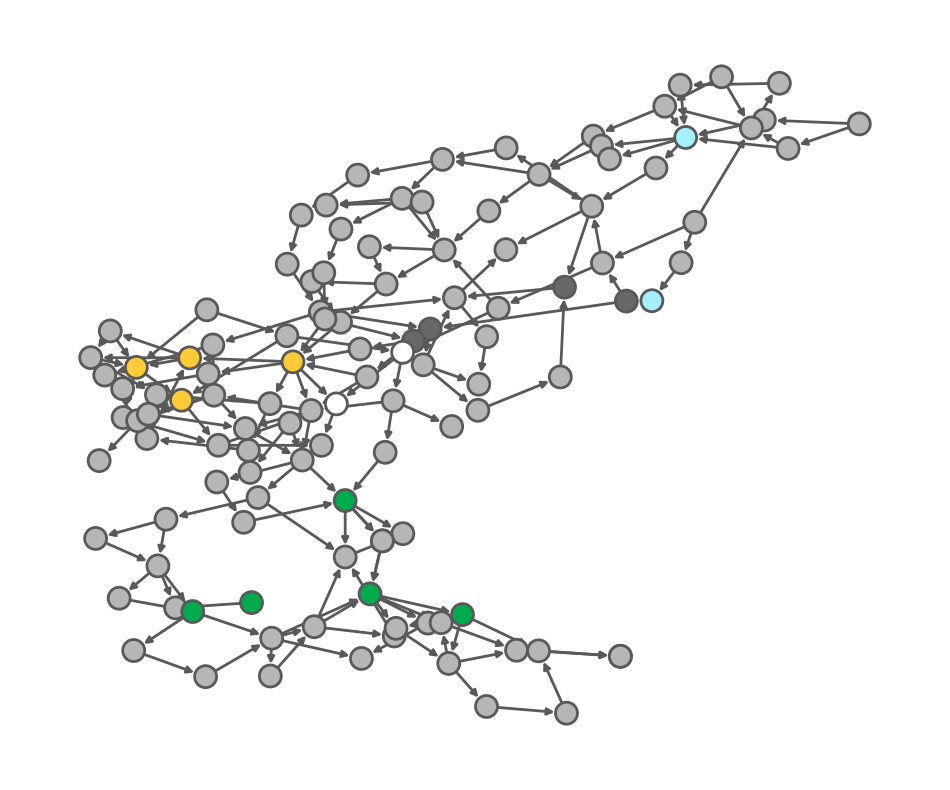

In [16]:
visualize_network(network)

In [17]:
def PSVareaOrifice(letter):
# from the PSV designation letter, output the PSV area in MM2
# create the table
    data = {"Designation": ["D","E","F","G","H","J","K","L","M","N","P","Q","R","T"],
        "typicalFlanges": ["1.5D2", "1.5E2", "1.5F3", "1.5G3", "2H3", "3J4", "3K4", "4L6", "4M6", "4N6", "4P6", "6Q8", "6R10", "8T10"],
        "areaIN2": [0.11, 0.20, 0.31, 0.50, 0.79, 1.29, 1.84, 2.85, 3.60, 4.34, 6.38, 11.05, 16.00, 26.00],
        "areaMM2": [70.9676, 126.4514, 198.0641, 324.5155, 506.4506, 830.3209, 1185.804, 1840.641, 2322.576, 2799.994, 4116.121, 7129.018, 10322.56, 16774.16] }

    psvTable = pd.DataFrame(data, columns = ["Designation", "typicalFlanges", "areaIN2", "areaMM2"])


    returnVal = psvTable[psvTable['Designation'].str.contains(letter)]
    return(returnVal.iloc[0]['areaMM2'])

In [18]:
print("Area (mm))",PSVareaOrifice("D"))


Area (mm)) 70.9676
